# 볼린저 밴드

상단 볼린저 밴드 = 중간 볼린저 밴드 + (2 * 표준편차)
중간 볼린저 밴드 = 종가의 20일 이동평균
하단 볼린저 밴드 = 중간 볼린저 밴드 - (2 * 표준편차)
밴드폭 = (상단 볼린저 밴드 - 하단 볼린저 밴드) / 중간 볼린저 밴드

%b = (종가 - 하단 볼린저 밴드) / (상단 볼린저 밴드 - 하단 볼린저 밴드)
- 상단 밴드 추세 %b -> 1 하단 밴드 추세 %b -> 0

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pymysql

from datetime import datetime, timedelta

"""매일 날짜를 수정해줄 수 없으니 yesterday변수를 만들어냄"""
yesterday = datetime.today() - timedelta(1)

In [2]:
class MarketDB:
    def __init__(self):
        """생성자: MariaDB 연결 및 종목코드 딕셔너리 생성"""
        self.conn = pymysql.connect(host='localhost', user='root', password='password', db='INVESTAR', charset='utf8')
        self.codes = dict()
        self.getCompanyInfo()
        
    def __del__(self):
        """소멸자: MariaDB 연결 해제"""
        self.conn.close()

    def getCompanyInfo(self):
        """company_info 테이블에서 읽어와서 companyData와 codes에 저장"""
        sql = "SELECT * FROM company_info"
        companyInfo = pd.read_sql(sql, self.conn)
        for idx in range(len(companyInfo)):
            self.codes[companyInfo['code'].values[idx]] = companyInfo['company'].values[idx]

    def getDailyPrice(self, code, startDate, endDate):
        """daily_price 테이블에서 읽어와서 데이터프레임으로 반환"""
        sql = "SELECT * FROM daily_price WHERE code = '{}' and date >= '{}' and date <= '{}'".format(code, startDate, endDate)
        df = pd.read_sql(sql, self.conn)
        df.index = df['date']
        return df

In [3]:
sd = MarketDB()
df = sd.getDailyPrice('현대자동차', '2020-05-14', str(yesterday))

In [4]:
df

,code,date,open,high,low,close,diff,volume
date,,,,,,,,


In [5]:
"""중간 볼린저 밴드인 20일 이평선을 만들어준다."""
df['MA20'] = df['close'].rolling(window=20).mean()
"""상단과 하단 볼린저 밴드를 구하는데 사용되는 표준편차를 만들어준다."""
df['stddev'] = df['close'].rolling(window=20).std()
"""상단 볼린저 밴드를 만들어준다"""
df['upper'] = df['MA20'] + df['stddev']
"""하단 볼린저 밴드를 만들어준다"""
df['lower'] = df['MA20'] - df['stddev']
"""%b를 만들어준다."""
df["PB"] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])
"""밴드 폭"""
df["bandWidth"] = (df['upper'] - df['lower']) / df['MA20']
"""20일 거래평균이니 20일의 기록이 쌓이기 전엔 NaN이므로 19일 이후로 한다"""
df = df[19:]

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

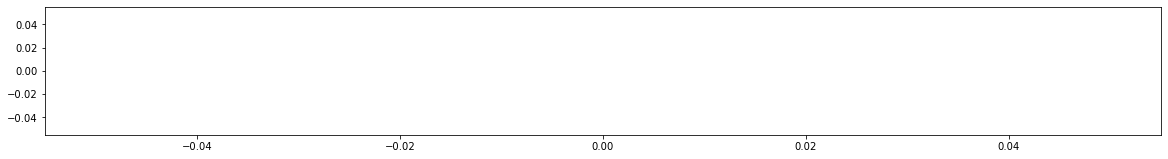

In [6]:
"""Bollinger Band Chart"""
plt.figure(figsize=(20, 8))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], color="#0000ff", label="Close")
plt.plot(df.index, df['upper'], 'r--', label="Upper")
plt.plot(df.index, df['lower'], 'c--', label="Lower")
plt.plot(df.index, df['MA20'], 'k--', label="MA20")
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
plt.title("Bollinger Band")
plt.legend(loc='best')

"""band 폭"""
plt.subplot(3, 1, 2)
plt.plot(df.index, df['bandWidth'], color="m", label='BandWidth')
plt.grid(True)
plt.legend(loc='best')

"""%b"""
plt.subplot(3, 1, 3)
plt.plot(df.index, df['PB'], color="b", label='%b')
plt.grid(True)
plt.legend(loc='best')

plt.show()